# Artifact Correction by AJDC-based Blind Source Separation

Blind source separation (BSS) based on approximate joint diagonalization of
Fourier cospectra (AJDC), applied to artifact correction of EEG [1]\_.


In [3]:
# Authors: Quentin Barthélemy & David Ojeda.
# EEG signal kindly shared by Marco Congedo.
#
# License: BSD (3-clause)

import gzip
import numpy as np
from matplotlib import pyplot as plt
from mne import create_info
from mne.io import RawArray
from mne.viz import plot_topomap
from mne.preprocessing import ICA
from scipy.signal import welch

from pyriemann.spatialfilters import AJDC
from pyriemann.utils.viz import plot_cospectra

In [4]:
def read_header(fname):
    """Read the header of sample-blinks.txt"""
    with gzip.open(fname, 'rt') as f:
        content = f.readline().split()
        return content[:-1], int(content[-1])

## Load EEG data


In [5]:
subject = "101"

In [6]:
import os
import mne
from pathlib import Path
from spectral.utils import print_date_time, read_parameters, config_project
from spectral.preproc import load_data, zapline_clean, get_bad_lof
from spectral.preproc import detrending, apply_pyprep, get_bad_channels
from spectral.viz import plot_step, plot_bad_channels
from spectral.viz import plot_epochs

import numpy as np

from spectral.ica import (
    compute_ica,
    label_components_ica,
    plot_ica_components,
    plot_removed_components,
)

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
raw_preproc_path = my_paths["raw_preproc_path"]
print(raw_preproc_path)
Path(raw_preproc_path).mkdir(parents=True, exist_ok=True)

figures_path = my_paths["figures_path"]

print_date_time()

Using matplotlib as 2D backend.
/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101/
2024-04-22 00:07:13


In [21]:
#fname = '../data/sample-blinks.txt.gz'
#signal_raw = np.loadtxt(fname, skiprows=1).T
#ch_names, sfreq = read_header(fname)
raw = load_data(subject, project_path=project_path).resample(250)

h_freq = 40
notch_freq = 50

filter_params = {
    "l_freq": 0.1,
    "h_freq": h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
}


raw_filtered = (
    raw.copy()
    .crop(tmin=0, tmax=300, include_tmax=True)
    .filter(**filter_params)
        .notch_filter(
        freqs=[50.0],
        phase="zero",
        method="iir"
    )
)
ch_names = signal_raw.ch_names
sfreq = signal_raw.info['sfreq']

ch_count = len(ch_names)
#duration = signal_raw.times[-1]/sfreq
signal_raw = raw_filtered.get_data()

Loading data from /Users/daniel/PhD/Projects/psd-path/data/raw/BIDS/sub-101/ses-01/eeg/sub-101_ses-01_task-rest_eeg.set
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16501 samples (66.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB



## Channel space


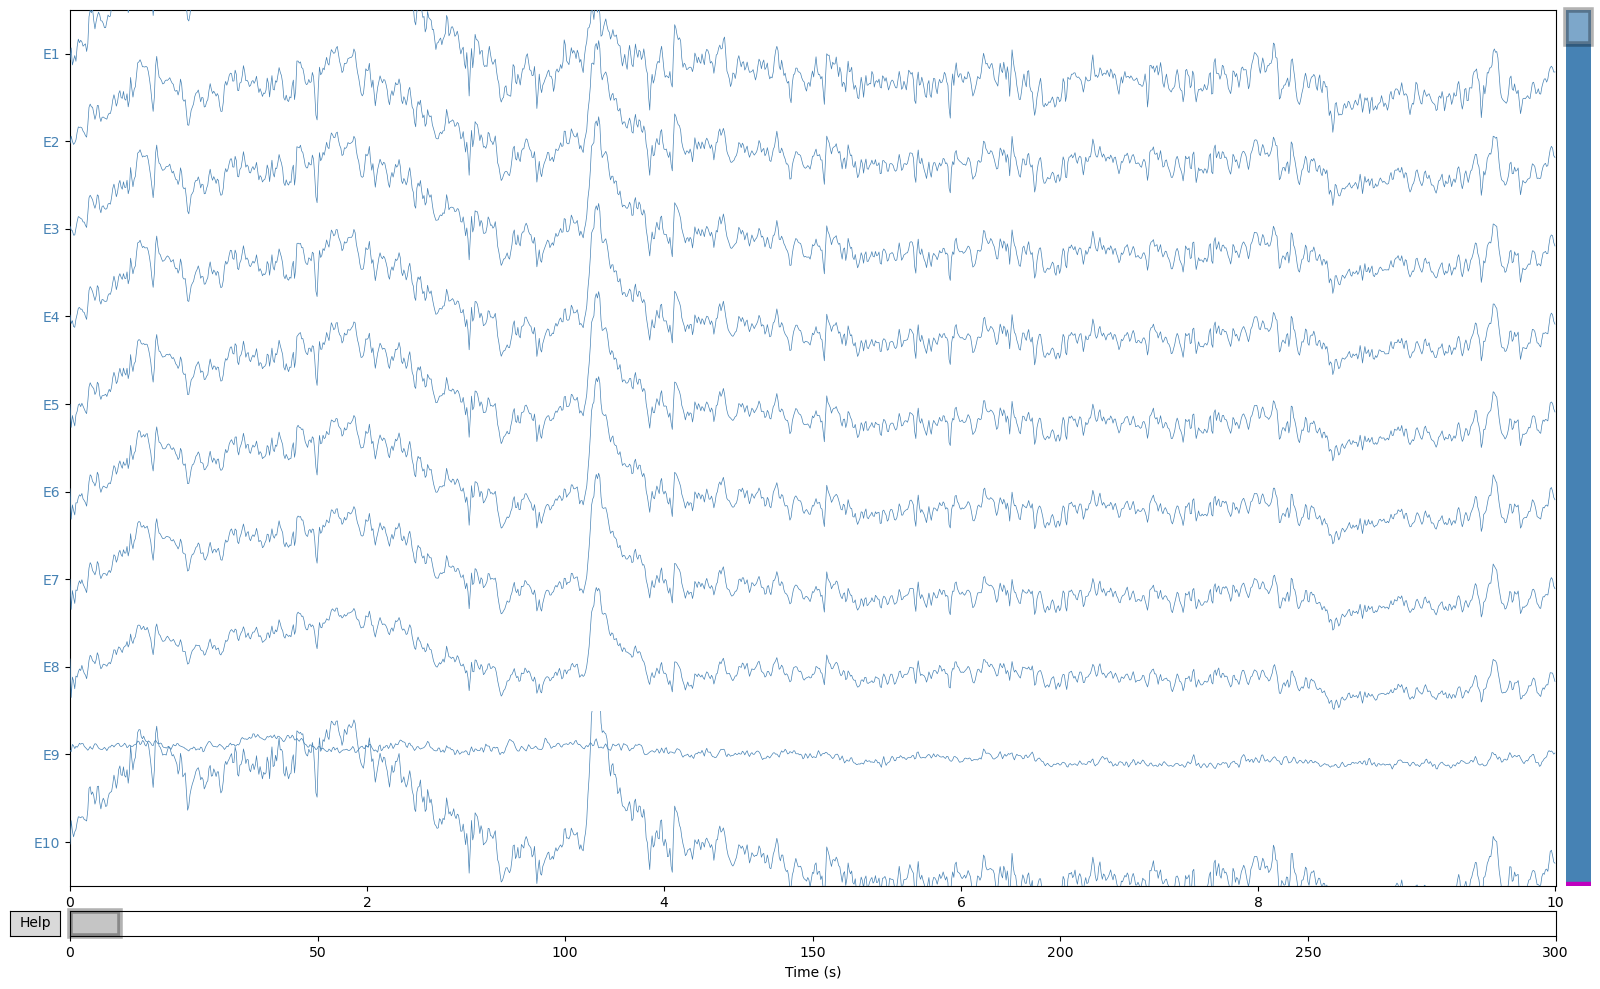

In [22]:
# Plot signal X
Ech_info = create_info(ch_names=ch_names, ch_types=['eeg'] * ch_count,
                      sfreq=sfreq)
#ch_info.set_montage('standard_1020')
#signal = RawArray(signal_raw, ch_info, verbose=False)
_ = raw_filtered.plot(duration=10, start=0, n_channels=10,
             color={'eeg': 'steelblue'},
            title='Original EEG signal', show_scalebars=False)

## AJDC: Second-Order Statistics (SOS)-based BSS, diagonalizing cospectra


Condition numbers: 
 array([1.00000000e+00, 2.77848595e+00, 3.67851189e+00, 4.61386659e+00,
       7.56782806e+00, 1.00381315e+01, 1.06791823e+01, 1.66448434e+01,
       1.75031779e+01, 2.16905850e+01, 2.85043542e+01, 3.61558154e+01,
       4.50506023e+01, 6.16323114e+01, 6.70311206e+01, 7.27063279e+01,
       8.17787843e+01, 9.25780741e+01, 1.07624789e+02, 1.17457710e+02,
       1.35381090e+02, 1.57766362e+02, 1.72248325e+02, 1.85235673e+02,
       2.21572819e+02, 2.31756544e+02, 2.62994097e+02, 2.89976243e+02,
       3.02568232e+02, 3.08747971e+02, 3.53011053e+02, 3.81972794e+02,
       4.00589214e+02, 4.58565442e+02, 5.29225642e+02, 5.61097158e+02,
       5.96372120e+02, 6.39545732e+02, 7.06081184e+02, 7.82877105e+02,
       8.11388006e+02, 8.61121558e+02, 9.04836915e+02, 9.90655663e+02,
       1.05663382e+03, 1.18183028e+03, 1.24725162e+03, 1.31170054e+03,
       1.32363233e+03, 1.36812963e+03, 1.43266820e+03, 1.43508398e+03,
       1.60962765e+03, 1.66325573e+03, 1.98357722e+03, 2

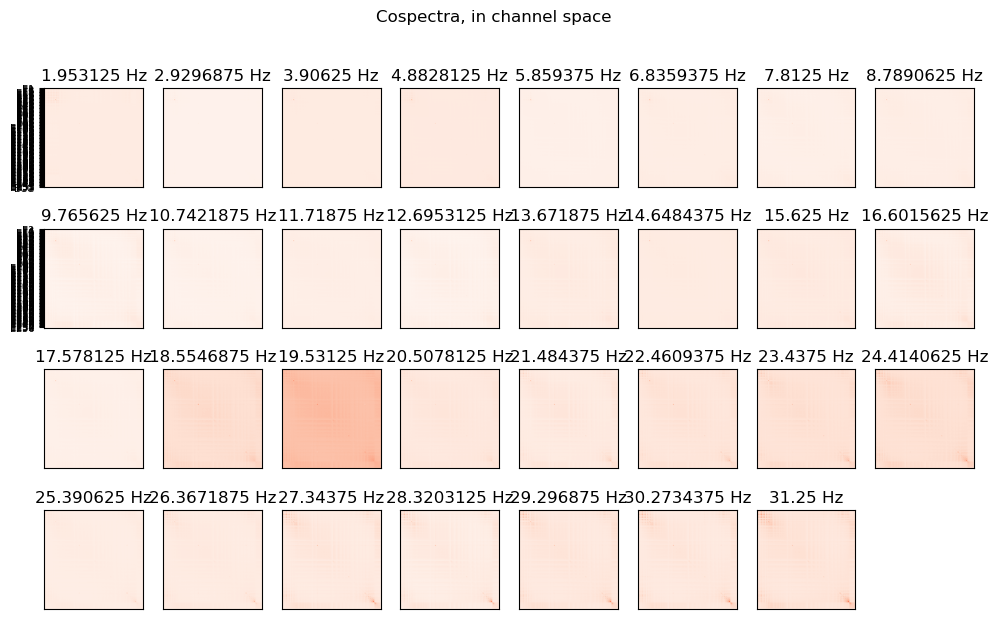

In [24]:
# Compute and diagonalize Fourier cospectral matrices between 1 and 32 Hz
window, overlap = sfreq, 0.5
fmin, fmax = 1, 32
ajdc = AJDC(window=window, overlap=overlap, fmin=fmin, fmax=fmax, fs=sfreq,
            dim_red={'max_cond': 100})
ajdc.fit(signal_raw[np.newaxis, np.newaxis, ...])
freqs = ajdc.freqs_

# Plot cospectra in channel space, after trace-normalization by frequency: each
# cospectrum, associated to a frequency, is a covariance matrix
_ =plot_cospectra(ajdc._cosp_channels, freqs, ylabels=ch_names,
               title='Cospectra, in channel space')

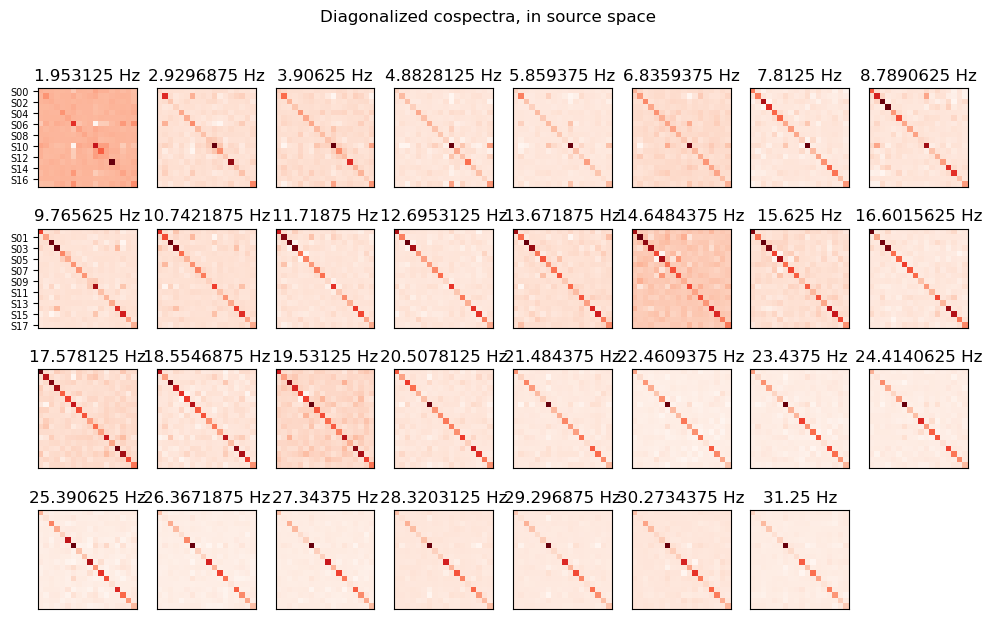

In [25]:
# Plot diagonalized cospectra in source space
sr_count = ajdc.n_sources_
sr_names = ['S' + str(s).zfill(2) for s in range(sr_count)]
_ = plot_cospectra(ajdc._cosp_sources, freqs, ylabels=sr_names,
               title='Diagonalized cospectra, in source space')

## Source space


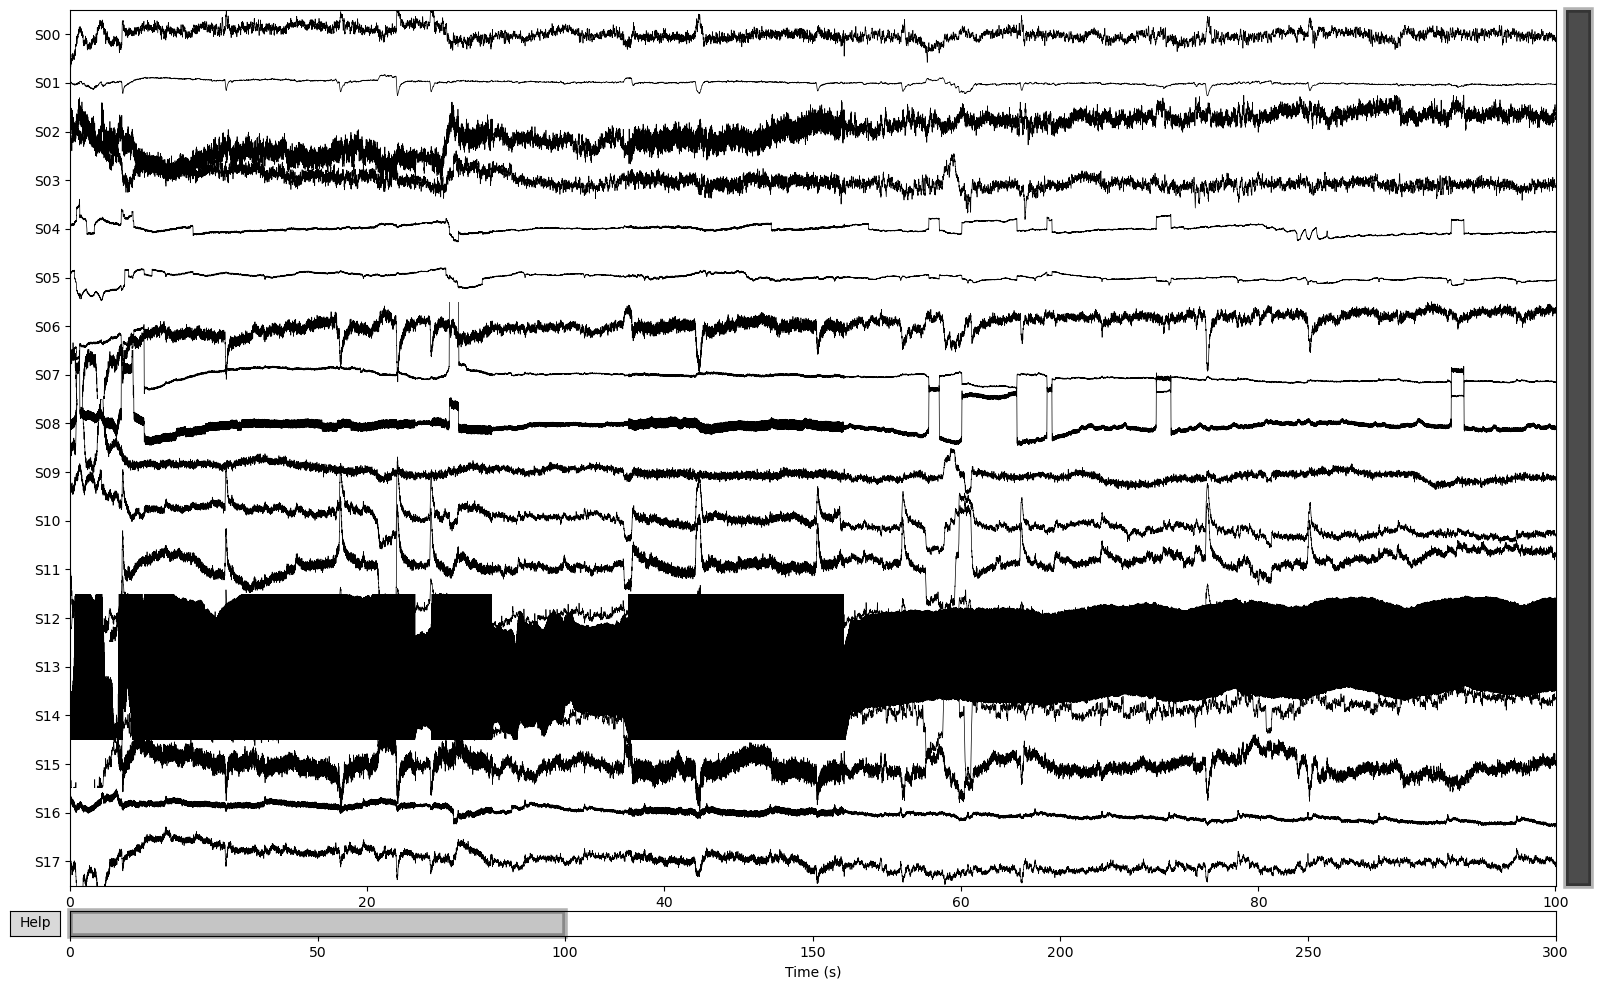

In [28]:
# Estimate sources S applying forward filters B to signal X: S = B X
source_raw = ajdc.transform(signal_raw[np.newaxis, ...])[0]

# Plot sources S
sr_info = create_info(ch_names=sr_names, ch_types=['misc'] * sr_count,
                      sfreq=sfreq)
source = RawArray(source_raw, sr_info, verbose=False)
_ = source.plot(duration=100, start=0, n_channels=sr_count, title='EEG sources estimated by AJDC',
            show_scalebars=False)

## Artifact identification


ValueError: x and y must have same first dimension, but have shapes (31,) and (32,)

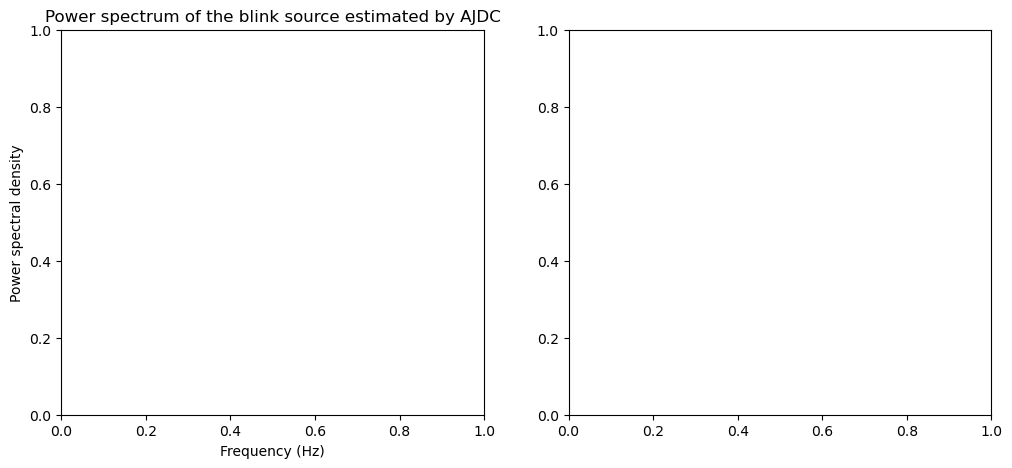

In [29]:
# Identify artifact by eye: blinks are well separated in source S0
blink_idx = 0

# Get normal spectrum, ie power spectrum after trace-normalization
blink_spectrum_norm = ajdc._cosp_sources[:, blink_idx, blink_idx]
blink_spectrum_norm /= np.linalg.norm(blink_spectrum_norm)

# Get absolute spectrum, ie raw power spectrum of the source
f, spectrum = welch(source.get_data(picks=[blink_idx]), fs=sfreq,
                    nperseg=window, noverlap=int(window * overlap))
blink_spectrum_abs = spectrum[0, (f >= fmin) & (f <= fmax)]
blink_spectrum_abs /= np.linalg.norm(blink_spectrum_abs)

# Get topographic map
blink_filter = ajdc.backward_filters_[:, blink_idx]

# Plot spectrum and topographic map of the blink source separated by AJDC
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].set(title='Power spectrum of the blink source estimated by AJDC',
           xlabel='Frequency (Hz)', ylabel='Power spectral density')
axs[0].plot(freqs, blink_spectrum_abs, label='Absolute power')
axs[0].plot(freqs, blink_spectrum_norm, label='Normal power')
axs[0].legend()
axs[1].set_title('Topographic map of the blink source estimated by AJDC')
plot_topomap(blink_filter, pos=ch_info, axes=axs[1], extrapolate='box')
plt.show()

## Artifact correction by BSS denoising


In [30]:
# BSS denoising: blink source is suppressed in source space using activation
# matrix D, and then applying backward filters A to come back to channel space
# Denoised signal: Xd = A D S
signal_denois_raw = ajdc.inverse_transform(source_raw[np.newaxis, ...],
                                           supp=[blink_idx])[0]

# Plot denoised signal Xd
signal_denois = RawArray(signal_denois_raw, ch_info, verbose=False)
signal_denois.plot(duration=duration, start=0, n_channels=ch_count,
                   scalings={'eeg': 3e1}, color={'eeg': 'steelblue'},
                   title='Denoised EEG signal by AJDC', show_scalebars=False)

NameError: name 'ch_info' is not defined

## Comparison with Independent Component Analysis (ICA)


In [31]:
# Infomax-based ICA is a Higher-Order Statistics (HOS)-based BSS, minimizing
# mutual information
ica = ICA(n_components=ajdc.n_sources_, method='infomax', random_state=42)
ica.fit(signal, picks='eeg')

# Plot sources separated by ICA
ica.plot_sources(signal, title='EEG sources estimated by ICA')

# Can you find the blink source?

NameError: name 'signal' is not defined

In [ ]:
# Plot topographic maps of sources separated by ICA
ica.plot_components(title='Topographic maps of EEG sources estimated by ICA')

## References

.. [1] [Online denoising of eye-blinks in electroencephalography](https://hal.archives-ouvertes.fr/hal-01660666/)
Q. Barthélemy, L. Mayaud, Y. Renard, D. Kim, S.-W. Kang, J. Gunkelman
and M. Congedo. Clinical Neurophysiology, Elsevier Masson, 2017, 47
(5-6), pp.371-391
